<a href="https://colab.research.google.com/github/Rajneeshzytox/all-ml-ai-projects/blob/main/SQLyne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SQLyne - Text to SQL By Rajneesh



> breaks the line between user and database



SQLyne is a Text-to-SQL tool that translates natural language queries into SQL code and fetch data from the database.

It's designed to make data access easier for those unfamiliar with SQL syntax.

<br>

<b>INSPIRED FROM MACSQL Research paper</b> - pdf https://arxiv.org/pdf/2312.11242


<br>

Read this [article](https://ninth-turner-e1c.notion.site/SQLyne-Text-to-SQL-Rajneeshzytox-131205724d95800e8f40eb5ba5ac408d) for future goals, problems and why i created SQLyne


**SQLyne diagram**:

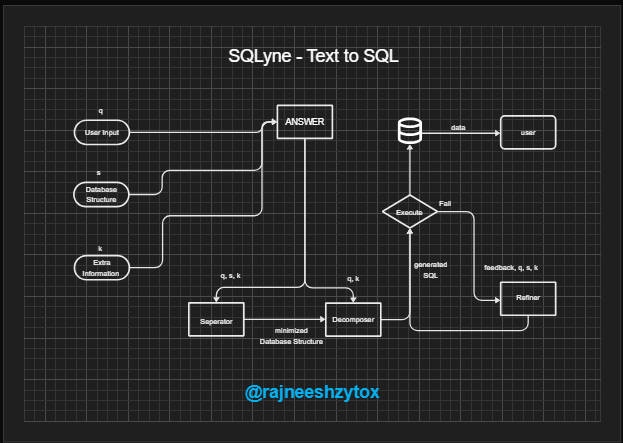

## SETUP MODEL

In [1]:
import google.generativeai as genai # for gemini model
import time # for time delay between api calls

In [2]:
# add your api key in collab `key icon` with name 'GOOGLE_API_KEY' and grant access

import os
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY

In [3]:
genai.configure(api_key=os.environ['GOOGLE_API_KEY']) # configure

In [4]:
# model = genai.Model.list() # Choose your model
model = genai.GenerativeModel('gemini-1.5-flash')

## AGENTS

sqlyne has 3 basic agents, which just send prompts to llm.

- **Seperator**: It seperate the database and choose relavant tables for better sql generation.
- **Decomposer**: It generates the sql.
- **Refiner**: It fix the sql

### Seperator


INFO SEPERATOR FUNTION:

it takes arg: (UserInput:str), (db_struct:dict/json), (db_extra_info:str <optional>)

it return : ( output_sep.text ) a minimized database structure

- **WHAT IS DOES?** :
 - it choose the only relevant part of the database that needed for the sql generation
 - choose and gives tables and columns that will need to generate sql easily.

- **Fun EXPLANATION:**
 - it has two prompts (example_to_extract_info) and (prompt_to_extract_info) which guide llm model to generate sql and prefered output.
 - it just give promts to llm model and return minimize database structure

- **(example_to_extract_info)**:
 - it should contains examples of inputs and outputs
 - their formats, rules

- **(prompt_to_extract_info)**:
 - it combines {UserInput}, {db_struct}, {db_extra_info}



In [5]:

def seperator(UserInput, db_struct, db_extra_info=None):
  # """ prompt with exampele to seperate"""
  example_to_extract_info = r'''
    EXAMPLE INPUTS:
    user input : "give me all the info about employees"
    db_structure : {
        'employees': ['id', 'name', 'salary'],
        'manager': ['id', 'name', 'salary', 'dob'],
        'assets': ['id', 'name', 'quantity'],
        'projects': ['id', 'project name', 'team leader', 'team members', 'due date']
    }
    extra_knowledge : {extra_knowledge}

    CORRECT OUTPUT: {'employees': ['id', 'name', 'salary']}
    WRONG OUTPUT :
    json\n{\n'employees': ['id', 'name', 'salary']\n}\n,
    \n{\n'employees': \n['id', 'name', 'salary'\n]\n}\n,
    \{\'employees': ['id', 'name', 'salary']\}\,

    '''
  prompt_to_extract_info = f'''\
    You are a Experienced database engineer. Your role is to extract information from the user query "{UserInput}".\
    And used that information and and extra info "{db_extra_info}",\
    to select the database tables from "{db_struct}" that are relevant to the user query.\
    Tables which can used to get information more efficently. Check for all the columns/attributes that are relevant to the user query.\
    \
    write a database structure that is minimal.\
    \
    With Follow these rules\
    - NO PREAMBLE.\
    - JUST THE STRUCTURE.\
    - NO EXPLANATIONS.9\
    - starting with "{" ending with "}"\
    - no any escape characters like "\n", "\t", "\b" etc. even inbetween "{" "}"\
    - no markdown\
    - only plain text\
    \
    -------------------------------------------------------------------------------\
    here is a example:\
    {example_to_extract_info}\
    \
    '''
  output_sep = model.generate_content(prompt_to_extract_info)
  return output_sep.text

### Decomposer

**INFO DECOMPOSER FUNTION:**

it takes args: (UserInput:str), (db_struct:dict/json), (db_extra_info:str <optional>)

it return : ( output_dec.text ) generated sql

- **Function EXPLANATION** :
 - it sends llm model, the data about user input query, minimized database structure (sent by seperator) and
 - the extra information about database.
 - return the generated sql from llm model.

- **(example_sql_gen):**
 - it should contains examples of inputs and outputs
 - their formats, rules

- **(prompt_to_generated_sql):**
 - it combines {UserInput}, {db_struct}, {db_extra_info} to genearte sql



In [6]:



def decomposer(UserInput, db_struct, db_extra_info=None):
  example_sql_gen = r'''
  EXAMPLE CASE:
      User Input:
        "List all students who have a marks above 3.5."
      Extra Knowledge:
        "The student data is stored in a table called 'students' with columns 'id', 'name', and 'marks'."
      Database Structure:
        "{students: [id, name, marks]}"

      Correct Output:
        SELECT * FROM students WHERE marks > 3.5

    Explanation Why this Output 'SELECT * FROM students WHERE marks > 3.5' is correct:
    - simple plain text, no code blocks
    - it is a valid sqllite3 syantax.
    - it follow the database structure which was "Table: students (id, name, marks)"
    - no any other extra column name or table.

    Wrong Outputs are:
    - markdown format
    - code blocks
    - answer with explanation, guides, preambles, conclusions
    '''

  prompt_to_generated_sql = f''' You are an experienced database engineer.\
      Your role is to generate SQL queries based on the user input "{UserInput}".\
      For the Database "{db_struct}". Use the information from "{db_extra_info}".\
      \
      Follow these rules:\
      \
      NO PREAMBLE.\
      JUST THE plain SQL COMMANDS.\
      NO EXPLANATIONS..\
      No escape characters like "\n", "\t", "\b",\
      No markdown.\
      NO code blocks\
      Only plain text.\
      Only the SQL statement is required.\
      \
      -----------------------------------------------------------------------------\
      \
      Here is a example:\
      {example_sql_gen}\
      \
      '''


  output_dec = model.generate_content(prompt_to_generated_sql)
  generated_sql = output_dec.text

  # ---------------- generated_sql preprocessing ---------------
  # llm sometimes generate sql like ```sql <codes> ```. which cause err.
  # we are remving ```sql ``` markdown code
  if generated_sql.startswith('```sql') and generated_sql.endswith('```'):
    generated_sql = str(generated_sql[6:-3].strip())
    # print("[from decomposer]: >> modified sql is ", generated_sql, '\n')
  return generated_sql


### Refiner

In [7]:
def refine_sql(sql_to_refine, userInput, db_struct, feedback_err, db_name, extra_knowledge=None):
  print('refiner running')
  # ----------- max try limit ------------
  max_try_to_fix_sql = 3

  for i in range(max_try_to_fix_sql + 1):

    # ------ max try limit reached i is 3 -------
    if i == max_try_to_fix_sql:
      print('\n>>> SQL REFINE FAILED\n')
      break

    print('-'*30)
    print(f'[from Refiner]>>> ERROR: \n{feedback_err}\n')
    print(f'[from Refiner]>>> try {i+1} to fix sql, waiting for 5 sec to re try\n')

    time.sleep(5)

    # ---------- prompt guiding llm to fix sql ------------
    prompt_to_fix_sql = f''' You are a database engineer. Your role is to fix given SQL {sql_to_refine}\
        error is {feedback_err} \
        according to the user input:{userInput},\
        database structure:{db_struct} database and\
          extra info about database: {extra_knowledge}.\
        \
        Your work is to\
        - remove code blocks, extra text, escape sequence\
        - fix sql\
        - re write text from markdown code block into plain text\
        - make it according to database and user input\
        \
        Rules: No Preample, Explanation, markdown, just plain SQL as string.\
        '''
    # -------- model call ----------
    gen_refined_sql = model.generate_content(prompt_to_fix_sql)
    sql_to_refine = gen_refined_sql.text


    # removing ```sql <code>``` markdown if any
    # ----------------------------------------------------------------------------------
    if sql_to_refine.lower().startswith('```sql') and sql_to_refine.endswith('```'):
      # print("[from refine2]: >> before generated sql is ", sql_to_refine, '\n')
      sql_to_refine = str(sql_to_refine[6:-3].strip())
      # print("[from refine2]: >> modified generated sql is ", sql_to_refine, '\n')
    # ----------------------------------------------------------------------------------



    # ------ trying running refined sql {sql_to_refine} -------
    try:
      data_from_db = execute_query(sql_to_refine, db_name)
      print('[from refiner] >>> sql is resolved')
      print('-'*30)

      # return data_from_db
      if not isinstance(data_from_db, dict):
        return data_from_db
      else:
        feedback_err = data_from_db['error']
        continue

    # if error :
    except Exception as err:
      feedback_err = err
      continue

  #---------- if problem not solved ---------
  # we will return dict indicating problem not solved,
  # we will check in ANSWER FUNCTION is type is dict. if dict means err not solved
  # return (sql_to_refine, feedback_err)
  print('[from refiner] >>> sql resolve Fail')
  return {'sql':sql_to_refine, 'error': feedback_err }

### Answer Function


INFO ANSWER FUNTION:

it takes parameter: q (User Input), db_struct (database structure), db_name, db_extra_info

- Function EXPLANATION :
 - it calls DECOMPOSER, SEPERATOR, REFINER
 - it execute sql and if sql fail it run refiner
 - returns the data if sql is execute successfully



In [8]:


def answer(q, db_struct, db_name, db_extra_info=None):
  mini_db_struct = seperator(q, db_struct, db_extra_info)
  # print("[from Answer/seperator] >>> ", mini_db_struct, '\n')

  time.sleep(2)
  generated_sql = decomposer(q, mini_db_struct, db_extra_info)
  # print("[from Answer/decomposer] >>>", generated_sql, '\n')



  try:
    time.sleep(2)
    Final_data = execute_query(generated_sql, db_name)
    # --------- we will get error as dict {'error': e} ----
    if not isinstance(Final_data, dict):
      return Final_data

    else:
      time.sleep(2)
      print('**********\nStarting REFINER\n**************')
      Final_data = refine_sql(generated_sql, q, db_struct, Final_data['error'], db_name, db_extra_info)

      # ------- checking if the refine fun was successful in solving query, -------
      # ------- returned data is dict means err not solved. [check Refine Fun for more details] -------
      if isinstance(Final_data, dict):
        print(f'\nSQL REFINE FAILED >>> ""{Final_data["sql"]}"" not solved\n')
        print(f'ERROR was : ""{Final_data["error"]}"" ')
        return


  except Exception as err:
    time.sleep(2)
    print('**********\nStarting REFINER\n**************')
    Final_data = refine_sql(generated_sql, q, db_struct, err, db_name, db_extra_info)

    # ------- checking if the refine fun was successful in solving query, -------
    # ------- returned data is dict means err not solved. [check Refine Fun for more details] -------
    if isinstance(Final_data, dict):
      print(f'\nSQL REFINE FAILED >>> SQL ""{Final_data["sql"]}"" not solved\n')
      print(f'ERROR was : ""{Final_data["error"]}"" ')
      return
    else:
      return Final_data


# SETUP DATABASE
we used sqllite3 for setup and testing

Read more about sql lite3 here:

https://docs.python.org/3/library/sqlite3.html#sqlite3-tutorial

In [9]:
import sqlite3

### EXECUTE FUNCTION

execute sql queries and return data from database.

Function execute_query runs the sql_query given,

it check if sql start with 'select' means user wants some data, and execute.

if error then return error message as dictionary

In [10]:
def execute_query(sql_query:str, mydatabase):
    conn = sqlite3.connect(mydatabase)
    cursor = conn.cursor()
    try:
        # Executing query
        data_from_db = cursor.execute(sql_query)

        # ------ if sql_query contains 'select' means user wants some data --------
        if sql_query.lower().startswith("select"):
            res = data_from_db.fetchall()
            conn.commit()
            conn.close()
            return res
        else:
            # ------ if sql_query does not contains 'select' means sql is of creating or updating something --------
            # print("[from Execute_sql]: >>> SQL doesn't contain SELECT")
            conn.commit()
            conn.close()
            return None


    # -- if execution fails, error code : ---
    except Exception as e:
        # ------ Print wrong sql query --------
        # print(f'[from Execute_sql]: >>> ErrorSQL\n***********\n{sql_query}\n***********\n')
        # ------ log error --------
        print(f"[from Execute_sql]: >>> Error executing query: {e}")
        conn.close()
        return {'error': str(e)}

## Test Database create

### **Test Db Struct**


**Tables**:

```
Students:

student_id (INT, Primary Key)
first_name (VARCHAR)
last_name (VARCHAR)
date_of_birth (DATE)
department_id (INT, Foreign Key referencing Departments)
```


```
Departments:

department_id (INT, Primary Key)
department_name (VARCHAR)
```


```
Courses:

course_id (INT, Primary Key)
course_name (VARCHAR)
department_id (INT, Foreign Key referencing Departments
```



```
Enrollments:

enrollment_id (INT, Primary Key)
student_id (INT, Foreign Key referencing Students)
course_id (INT, Foreign Key referencing Courses)
enrollment_date (DATE)
```

```
Faculty:

faculty_id (INT, Primary Key)
first_name (VARCHAR)
last_name (VARCHAR)
department_id (INT, Foreign Key referencing Departments)
```


```
CourseOfferings:

offering_id (INT, Primary Key)
course_id (INT, Foreign Key referencing Courses)
faculty_id (INT, Foreign Key referencing Faculty)
semester (VARCHAR)
year (INT)
```


In [11]:
### DATABASE CREATION ------------
# execute_query(q, db)
db_test = 'myTestDb.db'

## array of sql to run one by one
test_db_table_create_sql = ['''
CREATE TABLE Students (
    student_id INTEGER PRIMARY KEY,
    first_name VARCHAR(255),
    last_name VARCHAR(255),
    date_of_birth DATE,
    department_id INTEGER,
    FOREIGN KEY (department_id) REFERENCES Departments(department_id)
);''',

'''
CREATE TABLE  Departments (
    department_id INTEGER PRIMARY KEY,
    department_name VARCHAR(255)
);''',

'''
CREATE TABLE Courses (
    course_id INTEGER PRIMARY KEY,
    course_name VARCHAR(255),
    department_id INTEGER,
    FOREIGN KEY (department_id) REFERENCES Departments(department_id)
);''',

'''
CREATE TABLE Enrollments (
    enrollment_id INTEGER PRIMARY KEY,
    student_id INTEGER,
    course_id INTEGER,
    enrollment_date DATE,
    FOREIGN KEY (student_id) REFERENCES Students(student_id),
    FOREIGN KEY (course_id) REFERENCES Courses(course_id)
);''',

'''
CREATE TABLE Faculty (
    faculty_id INTEGER PRIMARY KEY,
    first_name VARCHAR(255),
    last_name VARCHAR(255),
    department_id INTEGER,
    FOREIGN KEY (department_id) REFERENCES Departments(department_id)
);''',

'''
CREATE TABLE CourseOfferings (
    offering_id INTEGER PRIMARY KEY,
    course_id INTEGER,
    faculty_id INTEGER,
    semester VARCHAR(255),
    year INTEGER,
    FOREIGN KEY (course_id) REFERENCES Courses(course_id),
    FOREIGN KEY (faculty_id) REFERENCES Faculty(faculty_id)
);'''
]

for i in test_db_table_create_sql:
  execute_query(i, db_test)

In [12]:
# ----------------- DB Structure ---------------------
db_test_struct = {
    'Students': ['student_id', 'first_name', 'last_name', 'date_of_birth', 'department_id'],
    'Departments': ['department_id', 'department_name'],
    'Courses': ['course_id', 'course_name', 'department_id'],
    'Enrollments': ['enrollment_id', 'student_id', 'course_id', 'enrollment_date'],
    'Faculty': ['faculty_id', 'first_name', 'last_name', 'department_id'],
    'CourseOfferings': ['offering_id', 'course_id', 'faculty_id', 'semester', 'year']
}

In [13]:
### Extra knowledge for model to know about db

test_db_extra_knowledge = '''\
Students and Departments: One-to-many relationship (one department can have many students).\
Joined using department_id\
\
Courses and Departments: One-to-many relationship (one department can offer many courses).\
Joined using department_id.\
\
Enrollments, Students, and Courses: Many-to-many relationship (students can enroll in many courses, and courses can have many students).\
Joined using student_id and course_id.\
\
Faculty and Departments: One-to-many relationship (one department can have many faculty members).\
Joined using department_id.\
\
CourseOfferings, Courses, and Faculty: Many-to-many relationship (faculty members can teach many courses in different offerings, and courses can be offered by different faculty members).\
Joined using course_id and faculty_id\
'''

### **DATA** **ENTRY**
you can skip this section... :)


```
INSERT INTO Students (student_id, first_name, last_name, date_of_birth, department_id)
VALUES (1,'first_name', 'last_name', 'yyyy-mm-dd', department_id);

```



```
INSERT INTO Departments (department_id, department_name)
VALUES ();

```



```
INSERT INTO Courses (course_id, course_name, department_id)
VALUES ();

```

```
INSERT INTO Enrollments (enrollment_id, student_id, course_id, enrollment_date)
VALUES ();
```


```
INSERT INTO Faculty (faculty_id, first_name, last_name, department_id)
VALUES ();

```

```
INSERT INTO CourseOfferings (offering_id, course_id, faculty_id, semester, year)
VALUES ();
```

#### department entry

In [14]:
# --- DEpartments entry ----- 😊
Departments = [
    'Computer Science',
    'Mathematics',
    'Physics',
    'Biology',
    'Chemistry',
    'English Literature',
    'History',
    'Business Administration'
]

for i in range(len(Departments)):
  dep_entry_query = f"""INSERT INTO Departments (department_id, department_name)
  VALUES ({i+1}, '{Departments[i]}');"""
  try:
    execute_query(dep_entry_query, db_test)
  except:
    print('somethign wrong')


# 1 'Computer Science',
# 2 'Mathematics',
# 3 'Physics',
# 4 'Biology',
# 5 'Chemistry',
# 6 'English Literature',
# 7 'History',
# 8 'Business Administration'

#### Course entry

In [15]:
# --- Courses entry ----- 🙄
# INSERT INTO Courses (course_id, course_name, department_id)


# {'course': department_id}
Courses = {
    'Introduction to Programming': 1,
    'Data Structures': 1,
    'Gen Ai': 1,
    'Machine Learning': 1,
    'Calculus': 2,
    'Trignometry': 2,
    'Statistics': 2,
    'Organic Chemistry': 4,
    'Mitocondria is power house of cell' : 4,
    'World History': 7,
    'Akhand Bharat ka Ithaas': 7,
    'English': 6,
    'Business study': 8,
    'Economics': 8
}


for crs, dep_id in Courses.items():
  crs_entry_query = f"""INSERT INTO Courses (course_name, department_id)
  VALUES ('{crs}', {dep_id});"""
  try:
    execute_query(crs_entry_query, db_test)
  except:
    print('somethign wrong')

#### falculty entry

In [16]:
# ----- falculty entry ----- 😕
# INSERT INTO Faculty (faculty_id, first_name, last_name, department_id)

# departments reference
# 1 'Computer Science',
# 2 'Mathematics',
# 3 'Physics',
# 4 'Biology',
# 5 'Chemistry',
# 6 'English Literature',
# 7 'History',
# 8 'Business Administration'


teachers = [
    ['tec1', 'computer', 1],
    ['tec2', 'math', 2],
    ['tec3', 'physics', 3],
    ['tec4', 'Biology', 4],
    ['tec5', 'Chemistry', 5],
    ['tec6', 'English', 6],
    ['tec7', 'History', 7],
    ['tec8', 'Business', 8],
    ['tec9', 'physics', 3],
    ['tec10', 'Chemistry', 5],
    ['tec11', 'computer', 1],
]

for i in teachers:
  fac_entry_query = f"""INSERT INTO Faculty (first_name, last_name, department_id)
  VALUES ('{i[0]}', '{i[1]}', {i[2]});"""
  try:
    execute_query(fac_entry_query, db_test)
  except:
    print('somethign wrong')


#### Students Entry

In [17]:
# --------------- students ---------------- 😢
# INSERT INTO Students (student_id, first_name, last_name, date_of_birth, department_id)

# departments reference
# 1 'Computer Science',
# 2 'Mathematics',
# 3 'Physics',
# 4 'Biology',
# 5 'Chemistry',
# 6 'English Literature',
# 7 'History',
# 8 'Business Administration'


stu_data = [
    ['stu1', 'comp', '2003-05-16', 1],
    ['stu2', 'comp', '2001-01-05', 1],
    ['stu3', 'comp', '2002-06-28', 1],
    ['stu4', 'comp', '2000-07-10', 1],
    ['stu5', 'comp', '2002-11-26', 1],
    ['stu6', 'maths', '2003-05-16', 2],
    ['stu7', 'maths', '2004-11-20', 2],
    ['stu8', 'bio', '2006-12-21', 4],
    ['stu9', 'bio', '2002-10-20', 4],
    ['stu10', 'Chemistry', '2001-09-06', 5],
    ['stu11', 'Chemistry', '2000-07-10', 5],
    ['stu13', 'English', '2002-06-11', 6],
    ['stu14', 'English', '2003-05-19', 6],
    ['stu15', 'History', '2005-03-13', 7],
    ['stu16', 'Business', '2003-01-02', 8],

]

for i in stu_data:
  stu_entry_query = f"""INSERT INTO Students (first_name, last_name, date_of_birth, department_id)
  VALUES ('{i[0]}', '{i[1]}', '{i[2]}', {i[3]});"""
  try:
    execute_query(stu_entry_query, db_test)
  except:
    print('somethign wrong')


#### Course OFFering ENtry

In [18]:
# ---- course offering ------ 😭
# INSERT INTO CourseOfferings (offering_id, course_id, faculty_id, semester, year)

## course reference
# 1    Introduction to Programming': 1,
# 2    'Data Structures': 1,
# 3    'Gen Ai': 1,
# 4    'Machine Learning': 1,
# 5    'Calculus': 2,
# 6    'Trignometry': 2,
# 7   'Statistics': 2,
# 8    'Organic Chemistry': 4,
# 9    'Mitocondria is power house of cell' : 4,
# 10    'World History': 7,
# 11    'Akhand Bharat ka Ithaas': 7,
# 12    'English': 6,
# 13    'Business study': 8,
# 14    'Economics': 8

## falculty refence
# 1   ['tec1', 'computer', 1],
# 2   ['tec2', 'math', 2],
# 3   ['tec3', 'physics', 3],
# 4   ['tec4', 'Biology', 4],
# 5   ['tec5', 'Chemistry', 5],
# 6   ['tec6', 'English', 6],
# 7   ['tec7', 'History', 7],
# 8   ['tec8', 'Business', 8],
# 9   ['tec9', 'physics', 3],
# 10   ['tec10', 'Chemistry', 5],
# 11   ['tec11', 'computer', 1],

# course_id, faculty_id, semester, year
course_offering_data = [
    [1, 1, 'first', 2024],
    [2, 11, 'third', 2025],
    [3, 11, 'first', 2024],
    [4, 11, 'third', 2025],
    [5, 2, 'second', 2024],
    [6, 2, 'second', 2024],
    [7, 2, 'first', 2024],
    [8, 4, 'first', 2024],
    [9, 4, 'second', 2024],
    [10, 7, 'third', 2025],
    [11, 7, 'first', 2025],
    [12, 6, 'second', 2024],
    [13, 8, 'third', 2025],
    [14, 8, 'first', 2024],
]

for i in course_offering_data:
    insert_query = f"""
    INSERT INTO CourseOfferings (course_id, faculty_id, semester, year)
    VALUES ({i[0]}, {i[1]}, '{i[2]}', {i[3]});
    """
    try:
        execute_query(insert_query, db_test)
    except:
        print('somethign wrong')

#### **Enrollment** **Entry**


In [19]:
## ---------- ENrollment enrty ----------- 💀
# INSERT INTO Enrollments (enrollment_id, student_id, course_id, enrollment_date)

# ------------------ REference ------------------
# students
# 1 ['stu1', 'comp', '2003-05-16', 1],
# 2 ['stu2', 'comp', '2001-01-05', 1],
# 3 ['stu3', 'comp', '2002-06-28', 1],
# 4 ['stu4', 'comp', '2000-07-10', 1],
# 5 ['stu5', 'comp', '2002-11-26', 1],
# 6 ['stu6', 'maths', '2003-05-16', 2],
# 7 ['stu7', 'maths', '2004-11-20', 2],
# 8 ['stu8', 'bio', '2006-12-21', 4],
# 9 ['stu9', 'bio', '2002-10-20', 4],
# 10 ['stu10', 'Chemistry', '2001-09-06', 5],
# 11 ['stu11', 'Chemistry', '2000-07-10', 5],
# 12 ['stu13', 'English', '2002-06-11', 6],
# 13 ['stu14', 'English', '2003-05-19', 6],
# 14 ['stu15', 'History', '2005-03-13', 7],
# 15 ['stu16', 'Business', '2003-01-02', 8],

## course reference
# 1    Introduction to Programming': 1,
# 2    'Data Structures': 1,
# 3    'Gen Ai': 1,
# 4    'Machine Learning': 1,
# 5    'Calculus': 2,
# 6    'Trignometry': 2,
# 7   'Statistics': 2,
# 8    'Organic Chemistry': 4,
# 9    'Mitocondria is power house of cell' : 4,
# 10    'World History': 7,
# 11    'Akhand Bharat ka Ithaas': 7,
# 12    'English': 6,
# 13    'Business study': 8,
# 14    'Economics': 8

# [student_id, course_id, enrollment_date]
enroll_data = [
    [1, 1, '2023-09-01'],   # stu1 enrolled in 'Introduction to Programming'...
    [1, 2, '2023-11-10'],
    [2, 1, '2023-09-11'],
    [2, 3, '2023-10-28'],
    [2, 7, '2023-03-16'],
    [3, 4, '2023-09-05'],
    [4, 5, '2023-01-25'],
    [5, 6, '2023-02-15'],
    [6, 7, '2023-04-20'],
    [7, 8, '2023-05-12'],
    [8, 9, '2023-06-15'],
    [9, 10, '2023-08-10'],
    [10, 11, '2023-09-08'],
    [11, 12, '2023-10-10'],
    [12, 13, '2023-11-22'],
    [13, 14, '2023-11-30'],
    [14, 10, '2023-12-01'],
    [15, 11, '2023-09-07'],
]


for i in enroll_data:
    insert_query = f"""
    INSERT INTO Enrollments (student_id, course_id, enrollment_date)
    VALUES ({i[0]}, {i[1]}, '{i[2]}');"""
    try:
        execute_query(insert_query, db_test)
    except:
        print('somethign wrong')

## TEST

Simple Test

In [20]:
# reference:
#   execute_query('SELECT DISTINCT course_name FROM Courses', db_test)
#   answer('all courses offered',db_test_struct, db_test, test_db_extra_knowledge)

## ----------- simple queries test ----------------
## level 0 🤗
simple_test = [
    'what are the courses offered', # pass
    'list all teachers with full name', # pass
    'list all students full name', # pass
    'how many departments are there', # pass
]

for i in simple_test:
  print('-'*30)
  print(f"\nDATA FOR QUERY {i} is: ")
  print(answer(i, db_test_struct, db_test, test_db_extra_knowledge))
  print('-'*30)

------------------------------

DATA FOR QUERY what are the courses offered is: 
[('Introduction to Programming',), ('Data Structures',), ('Gen Ai',), ('Machine Learning',), ('Calculus',), ('Trignometry',), ('Statistics',), ('Organic Chemistry',), ('Mitocondria is power house of cell',), ('World History',), ('Akhand Bharat ka Ithaas',), ('English',), ('Business study',), ('Economics',)]
------------------------------
------------------------------

DATA FOR QUERY list all teachers with full name is: 
[('tec1', 'computer'), ('tec2', 'math'), ('tec3', 'physics'), ('tec4', 'Biology'), ('tec5', 'Chemistry'), ('tec6', 'English'), ('tec7', 'History'), ('tec8', 'Business'), ('tec9', 'physics'), ('tec10', 'Chemistry'), ('tec11', 'computer')]
------------------------------
------------------------------

DATA FOR QUERY list all students full name is: 
[('stu1 comp',), ('stu2 comp',), ('stu3 comp',), ('stu4 comp',), ('stu5 comp',), ('stu6 maths',), ('stu7 maths',), ('stu8 bio',), ('stu9 bio',), 

In [21]:
## test Joins 😐

TEST_QUERY = [
    'give all students names who are studying intro to programming', # fail
    'give all students names who are studying introduction to programming', # pass
    'write which student is in which course', # pass
]

for i in TEST_QUERY:
  print('-'*30)
  print(f"\nDATA FOR QUERY {i} is: ")
  print(answer(i, db_test_struct, db_test, test_db_extra_knowledge))
  print('-'*30)

------------------------------

DATA FOR QUERY give all students names who are studying intro to programming is: 
[]
------------------------------
------------------------------

DATA FOR QUERY give all students names who are studying introduction to programming is: 
[('stu1', 'comp'), ('stu2', 'comp')]
------------------------------
------------------------------

DATA FOR QUERY write which student is in which course is: 
[('stu1', 'comp', 'Introduction to Programming'), ('stu1', 'comp', 'Data Structures'), ('stu2', 'comp', 'Introduction to Programming'), ('stu2', 'comp', 'Gen Ai'), ('stu2', 'comp', 'Statistics'), ('stu3', 'comp', 'Machine Learning'), ('stu4', 'comp', 'Calculus'), ('stu5', 'comp', 'Trignometry'), ('stu6', 'maths', 'Statistics'), ('stu7', 'maths', 'Organic Chemistry'), ('stu8', 'bio', 'Mitocondria is power house of cell'), ('stu9', 'bio', 'World History'), ('stu10', 'Chemistry', 'Akhand Bharat ka Ithaas'), ('stu11', 'Chemistry', 'English'), ('stu13', 'English', 'Busin

In [22]:
# test irrelavant query 😶

TEST_QUERY = [
    'sum of salary of all employees',
    'who is prime minister of india',
    'why earth is round',
]

for i in TEST_QUERY:
  print('-'*30)
  print(f"\nDATA FOR QUERY {i} is: ")
  print(answer(i, db_test_struct, db_test, test_db_extra_knowledge))
  print('-'*30)

------------------------------

DATA FOR QUERY sum of salary of all employees is: 
[from Execute_sql]: >>> Error executing query: no such column: salary
**********
Starting REFINER
**************
refiner running
------------------------------
[from Refiner]>>> ERROR: 
no such column: salary

[from Refiner]>>> try 1 to fix sql, waiting for 5 sec to re try

[from Execute_sql]: >>> Error executing query: no such column: salary
[from refiner] >>> sql is resolved
------------------------------
------------------------------
[from Refiner]>>> ERROR: 
no such column: salary

[from Refiner]>>> try 2 to fix sql, waiting for 5 sec to re try

[from Execute_sql]: >>> Error executing query: no such column: f.salary
[from refiner] >>> sql is resolved
------------------------------
------------------------------
[from Refiner]>>> ERROR: 
no such column: f.salary

[from Refiner]>>> try 3 to fix sql, waiting for 5 sec to re try

[from Execute_sql]: >>> Error executing query: no such column: f.salary
[f